In [55]:
!pip uninstall pandas -y

Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2


In [56]:
!pip install pandas==2.0.3

  Using cached pandas-2.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
river 0.21.1 requires pandas<3.0,>=2.1, but you have pandas 2.0.3 which is incompatible.


In [57]:
import pandas as pd


In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy.stats import shapiro
from imblearn.over_sampling import SMOTE
import time

In [59]:
import warnings
warnings.filterwarnings('ignore')

In [60]:
df=pd.read_csv("/content/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")

In [61]:
df.columns


Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [62]:
df['Label'] = df[' Label']

In [63]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [64]:
# Define the automated data encoding function
def Auto_Encoding(df):
    cat_features=[x for x in df.columns if df[x].dtype=="object"] ## Find string/text features
    le=LabelEncoder()
    for col in cat_features:
        if col in df.columns:
            i = df.columns.get_loc(col)
            # Transform to numerical features
            df.iloc[:,i] = df.apply(lambda i:le.fit_transform(i.astype(str)), axis=0, result_type='expand')
    return df

In [65]:
df=Auto_Encoding(df)

## Automated Imputation
Detect and impute missing values to improve data quality

In [66]:
# Define the automated data imputation function
def Auto_Imputation(df):
    if df.isnull().values.any() or np.isinf(df).values.any(): # if there is any empty or infinite values
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(0, inplace = True)  # Replace empty values with zeros; there are other imputation methods discussed in the paper
    return df

In [67]:
df=Auto_Imputation(df)

## Automated normalization
Normalize the range of features to a similar scale to improve data quality

In [68]:
def Auto_Normalization(df):
    stat, p = shapiro(df)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    numeric_features = df.drop(['Label'],axis = 1).dtypes[df.dtypes != 'object'].index

    # check if the data distribution follows a Gaussian/normal distribution
    # If so, select the Z-score normalization method; otherwise, select the min-max normalization
    # Details are in the paper
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
        df[numeric_features] = df[numeric_features].apply(
            lambda x: (x - x.mean()) / (x.std()))
        print('Z-score normalization is automatically chosen and used')
    else:
        print('Sample does not look Gaussian (reject H0)')
        df[numeric_features] = df[numeric_features].apply(
            lambda x: (x - x.min()) / (x.max()-x.min()))
        print('Min-max normalization is automatically chosen and used')
    return df

In [69]:
df=Auto_Normalization(df)

Statistics=0.041, p=0.000
Sample does not look Gaussian (reject H0)
Min-max normalization is automatically chosen and used


In [70]:
# Remove irrelevant features and select important features
def Feature_Importance_IG(data):
    features = data.drop(['Label'],axis=1).values  # "Label" should be changed to the target class variable name if different
    labels = data['Label'].values

    # Extract feature names
    feature_names = list(data.drop(['Label'],axis=1).columns)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    model = lgb.LGBMRegressor(verbose = -1)
    model.fit(features, labels)
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})

    # Sort features according to importance
    feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

    # Normalize the feature importances to add up to one
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

    cumulative_importance=0.90 # Only keep the important features with cumulative importance scores>=90%. It can be changed.

    # Make sure most important features are on top
    feature_importances = feature_importances.sort_values('cumulative_importance')

    # Identify the features not needed to reach the cumulative_importance
    record_low_importance = feature_importances[feature_importances['cumulative_importance'] > cumulative_importance]

    to_drop = list(record_low_importance['feature'])
#     print(feature_importances.drop(['importance'],axis=1))
    return to_drop

In [71]:
def Feature_Redundancy_Pearson(data):
    correlation_threshold = 0.90
    features = data.drop(['Label'], axis=1)
    corr_matrix = features.corr()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

    return to_drop

In [72]:
def Auto_Feature_Engineering(df):
    drop1 = Feature_Importance_IG(df)
    dfh1 = df.drop(columns=drop1)

    drop2 = Feature_Redundancy_Pearson(dfh1)
    dfh2 = dfh1.drop(columns=drop2)

    return dfh2

In [73]:
dfh2 = Auto_Feature_Engineering(df)
dfh2

,Destination Port,Label,Label
0,0.000336,0.027805,403
1,0.000336,0.027805,403
2,0.000336,0.027805,403
3,0.000336,0.027805,403
4,0.541314,0.087484,1268
...,...,...,...
286462,0.006775,0.242928,3521
286463,0.006775,0.242928,3521
286464,0.006775,0.242928,3521
286465,0.006775,0.242928,3521


In [74]:
a=dfh2.columns

In [75]:
type(dfh2)

pandas.core.frame.DataFrame

In [128]:
dfh2.columns

Index([' Destination Port', ' Label', 'Label'], dtype='object')

In [76]:
dfh2.to_csv('output_data.csv', index=False)

In [126]:
d=pd.read_csv("output_data.csv")

In [127]:
d.columns

Index([' Destination Port', ' Label', 'Label'], dtype='object')

In [87]:
# Assuming 0 is normal and anything else is an anomaly
df['Label'] = (df['Label'] != 0).astype(int)

In [88]:
from imblearn.under_sampling import RandomUnderSampler

# Initialize the under-sampler
rus = RandomUnderSampler(random_state=0)

# Fit and apply the transform to the dataset
X = df.drop('Label', axis=1)  # Assuming 'Label' is the target column
y = df['Label']
X_resampled, y_resampled = rus.fit_resample(X, y)

# Check the imbalance after resampling
print(y_resampled.value_counts())


Label
0    101
1    101
Name: count, dtype: int64


In [89]:
from sklearn.model_selection import train_test_split

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [90]:
'''X = dfh2.drop(['Label'],axis=1)
y = dfh2['Label']


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)'''

"X = dfh2.drop(['Label'],axis=1)\ny = dfh2['Label']\n\n\n#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)"

In [91]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [92]:
#pd.Series(y_train).value_counts()

In [93]:
from imblearn.over_sampling import SMOTE

In [94]:
'''from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, train_size=0.2, test_size=0.8, stratify=y_resampled, random_state=0)'''

'from imblearn.over_sampling import SMOTE\n\nsmote = SMOTE(random_state=0)\nX_resampled, y_resampled = smote.fit_resample(X, y)\n\nX_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, train_size=0.2, test_size=0.8, stratify=y_resampled, random_state=0)'

In [95]:
def Auto_Balancing(X_train, y_train):
    number0 = y_train.value_counts().iloc[0]
    number1 = y_train.value_counts().iloc[1]

    if number0 > number1:
        nlarge = number0
    else:
        nlarge = number1

    if (number1 / number0 > 1.5) or (number0 / number1 > 1.5):
        smote = SMOTE(n_jobs=-1, sampling_strategy={0: nlarge, 1: nlarge})
        X_train, y_train = smote.fit_resample(X_train, y_train)

    return X_train, y_train

In [96]:
'''!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE'''

'!pip install imbalanced-learn\nfrom imblearn.over_sampling import SMOTE'

In [97]:
X_train, y_train = Auto_Balancing(X_train, y_train)

In [98]:
pd.Series(y_train).value_counts()

Label
1    82
0    79
Name: count, dtype: int64

In [99]:
!pip show river

Name: river
Version: 0.21.1
Summary: Online machine learning in Python
Home-page: https://riverml.xyz/
Author: Max Halford
Author-email: maxhalford25@gmail.com
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, pandas, polars, scipy
Required-by: 


In [100]:
!pip install river

  Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.


In [101]:
!pip install --upgrade river

In [102]:
!pip install river[extras]


In [103]:
from river import drift


In [104]:
!pip install git+https://github.com/online-ml/river --upgrade


  Cloning https://github.com/online-ml/river to /tmp/pip-req-build-c3d6ysyn
  Running command git clone --filter=blob:none --quiet https://github.com/online-ml/river /tmp/pip-req-build-c3d6ysyn
  Resolved https://github.com/online-ml/river to commit 6995f1522a9136fd3982890afac5c4a178e4cd57
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [105]:

!pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [106]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from river import tree, metrics, stream
from river import ensemble, linear_model
from river import neighbors, naive_bayes
from river import drift
from river import metrics
from river import stream
from river import tree, neighbors, naive_bayes, ensemble, linear_model
from river.drift import ADWIN

In [107]:
def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy()  # Use accuracy as the metric
    i = 0  # count the number of evaluated data points
    t = []  # record the number of evaluated data points
    m = []  # record the real-time accuracy
    yt = []  # record all the true labels of the test set
    yp = []  # record all the predicted labels of the test set

    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        model.learn_one(xi1, yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred = model.predict_one(xi)  # Predict the test sample
        model.learn_one(xi, yi)  # Learn the test sample
        metric.update(yi, y_pred)  # Update the real-time accuracy
        t.append(i)
        m.append(metric.get() * 100)
        yt.append(yi)
        yp.append(y_pred)
        i += 1

    print("Accuracy: " + str(round(accuracy_score(yt, yp), 5) * 100) + "%")
    print("Precision: " + str(round(precision_score(yt, yp), 5) * 100) + "%")
    print("Recall: " + str(round(recall_score(yt, yp), 5) * 100) + "%")
    print("F1-score: " + str(round(f1_score(yt, yp), 5) * 100) + "%")

    return t, m


In [108]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on CICIDS2017 dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

In [109]:
if pd.isnull(X).any().any() or pd.isnull(y).any():
    print("Missing values detected in data!")

Missing values detected in data!


In [110]:
from river.metrics import Accuracy

In [111]:
#metric = metrics.Accuracy()

In [112]:
'''name1 = "HT model"
model1 = tree.HoeffdingTreeClassifier()  # Define the model
learn_and_evaluate(model1, X_train, y_train, X_test, y_test)'''

'name1 = "HT model"\nmodel1 = tree.HoeffdingTreeClassifier()  # Define the model\nlearn_and_evaluate(model1, X_train, y_train, X_test, y_test)'

In [113]:
'''%%time
# Use the Hoeffding Tree (HT) model
name1 = "HT model"
model1 = tree.HoeffdingTreeClassifier() # Define the model
t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1)'''

'%%time\n# Use the Hoeffding Tree (HT) model\nname1 = "HT model"\nmodel1 = tree.HoeffdingTreeClassifier() # Define the model\nt, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset\nacc_fig(t, m1, name1)'

In [114]:
'''%%time
# Use the Leveraging Bagging (LB) model
name2 = "LB model"
model2 = ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(),n_models=3) # Define the model
t, m2 = adaptive_learning(model2, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m2, name2) # Draw the figure of how the real-time accuracy changes with the number of samples'''

'%%time\n# Use the Leveraging Bagging (LB) model\nname2 = "LB model"\nmodel2 = ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(),n_models=3) # Define the model\nt, m2 = adaptive_learning(model2, X_train, y_train, X_test, y_test) # Learn the model on the dataset\nacc_fig(t, m2, name2) # Draw the figure of how the real-time accuracy changes with the number of samples'

In [115]:
from river import ensemble

Accuracy: 87.805%
Precision: 81.818%
Recall: 94.73700000000001%
F1-score: 87.805%
CPU times: user 2.43 s, sys: 146 ms, total: 2.57 s
Wall time: 2.62 s


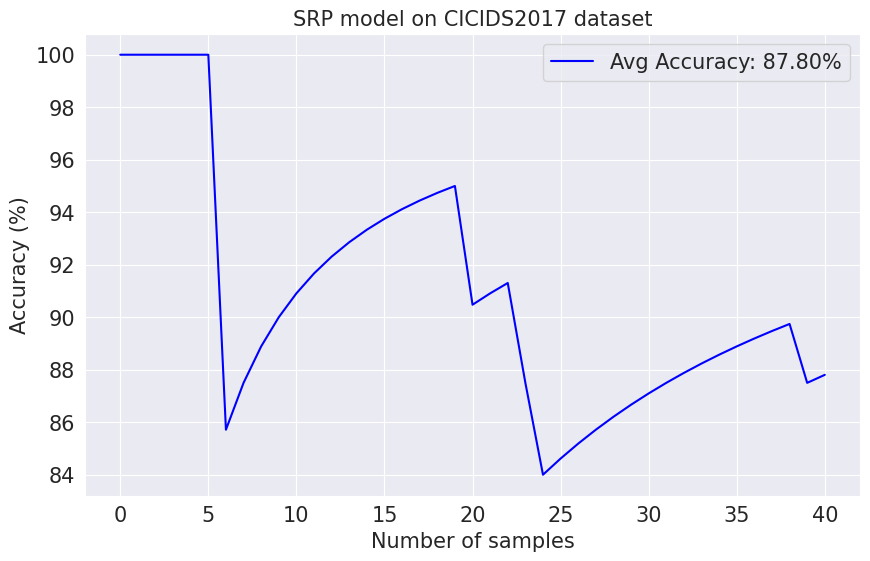

In [116]:
%%time
# Use the Streaming Random Patches (SRP) model with ADWIN drift detector
name4 = "SRP model"
model4 = ensemble.SRPClassifier(n_models = 3) # Define the model
t, m4 = adaptive_learning(model4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m4, name4) # Draw the figure of how the real-time accuracy changes with the number of samples

In [117]:
# Draw a comprehensive figure to compare the performance of all models
'''plt.rcParams.update({'font.size': 30})
plt.figure(1,figsize=(24,15))
sns.set_style("darkgrid")
plt.clf()

# Plot the accuracy change of each learner
plt.plot(t,m1,'-b',label=name1+', Avg Accuracy: %.2f%%'%(m1[-1]))
plt.plot(t,m2,'-g',label=name2+', Avg Accuracy: %.2f%%'%(m2[-1]))
#plt.plot(t,m3,'orange',label=name3+', Avg Accuracy: %.2f%%'%(m3[-1]))
plt.plot(t,m4,'black',label=name4+', Avg Accuracy: %.2f%%'%(m4[-1]))

# Draw the drift points/time
dr = [0,9900,12600, 14200,15800,18800,21600]
for i in range(len(dr)):
    if i!=0:
        plt.text(dr[i]-500, 100.2, 'Drift '+str(i), c = "red", fontsize = 25)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=4, linestyles = "dashed")

plt.legend(loc='lower right')
plt.ylim(85, 100.8)
plt.title('Online Learning Methods Comparison on CICIDS2017', fontsize=40)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy (%)')

plt.draw()'''

'plt.rcParams.update({\'font.size\': 30})\nplt.figure(1,figsize=(24,15))\nsns.set_style("darkgrid")\nplt.clf()\n\n# Plot the accuracy change of each learner\nplt.plot(t,m1,\'-b\',label=name1+\', Avg Accuracy: %.2f%%\'%(m1[-1]))\nplt.plot(t,m2,\'-g\',label=name2+\', Avg Accuracy: %.2f%%\'%(m2[-1]))\n#plt.plot(t,m3,\'orange\',label=name3+\', Avg Accuracy: %.2f%%\'%(m3[-1]))\nplt.plot(t,m4,\'black\',label=name4+\', Avg Accuracy: %.2f%%\'%(m4[-1]))\n\n# Draw the drift points/time\ndr = [0,9900,12600, 14200,15800,18800,21600]\nfor i in range(len(dr)):\n    if i!=0:\n        plt.text(dr[i]-500, 100.2, \'Drift \'+str(i), c = "red", fontsize = 25)\n        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=4, linestyles = "dashed")\n\nplt.legend(loc=\'lower right\')\nplt.ylim(85, 100.8)\nplt.title(\'Online Learning Methods Comparison on CICIDS2017\', fontsize=40)\nplt.xlabel(\'Number of samples\')\nplt.ylabel(\'Accuracy (%)\')\n\nplt.draw()'

In [118]:
'''# Define a generic adaptive learning function
# The argument "model" means an online adaptive learning algorithm
def adaptive_learning_model_selection(model_list, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set
    ypb = [] # record all the predicted labels of the test set for the best performing model
    acc_b = 0 # The best accuracy score
    mb = [] # record the real-time accuracy of the best performing model

    for model in model_list:
        # Learn the training set
        for xi1, yi1 in stream.iter_pandas(X_train, y_train):
            model.learn_one(xi1,yi1)

        # Predict the test set
        for xi, yi in stream.iter_pandas(X_test, y_test):
            y_pred= model.predict_one(xi)  # Predict the test sample
            model.learn_one(xi,yi) # Learn the test sample
            metric = metric.update(yi, y_pred) # Update the real-time accuracy
            t.append(i)
            m.append(metric.get()*100)
            yt.append(yi)
            yp.append(y_pred)
            i = i+1
#         print(accuracy_score(yt,yp))
        if accuracy_score(yt,yp)>acc_b:
            acc_b = accuracy_score(yt,yp)
            mb = m
            ypb = yp
            model_b = model

    print(model_b)
    print("Accuracy: "+str(round(accuracy_score(yt,ypb),5)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,ypb),5)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,ypb),5)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,ypb),5)*100)+"%")
    return t, mb'''

'# Define a generic adaptive learning function\n# The argument "model" means an online adaptive learning algorithm\ndef adaptive_learning_model_selection(model_list, X_train, y_train, X_test, y_test):\n    metric = metrics.Accuracy() # Use accuracy as the metric\n    i = 0 # count the number of evaluated data points\n    t = [] # record the number of evaluated data points\n    m = [] # record the real-time accuracy\n    yt = [] # record all the true labels of the test set\n    yp = [] # record all the predicted labels of the test set\n    ypb = [] # record all the predicted labels of the test set for the best performing model\n    acc_b = 0 # The best accuracy score\n    mb = [] # record the real-time accuracy of the best performing model\n\n    for model in model_list:\n        # Learn the training set\n        for xi1, yi1 in stream.iter_pandas(X_train, y_train):\n            model.learn_one(xi1,yi1)\n\n        # Predict the test set\n        for xi, yi in stream.iter_pandas(X_test, 

SRP with the highest accuracy is selected as the best/most suitable online learner

In [119]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the objective function
def objective(params):
    params = {
        'n_models': int(params['n_models']),
        'subspace_size': abs(float(params['subspace_size'])),
    }
    clf = ensemble.SRPClassifier( **params)

    t, m = adaptive_learning(clf, X_train, y_train, X_test, y_test)

    return {'loss':-m[-1], 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_models': hp.quniform('n_models', 2, 10, 1),
    "subspace_size":hp.uniform('subspace_size', 0.3, 1),
}

# Detect the optimal hyperparameter values
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("SRP: Hyperopt estimated optimum {}".format(best))

'from hyperopt import hp, fmin, tpe, STATUS_OK, Trials\nfrom sklearn.model_selection import cross_val_score, StratifiedKFold\n\n# Define the objective function\ndef objective(params):\n    params = {\n        \'n_models\': int(params[\'n_models\']),\n        \'subspace_size\': abs(float(params[\'subspace_size\'])),\n    }\n    clf = ensemble.SRPClassifier( **params)\n\n    t, m = adaptive_learning(clf, X_train, y_train, X_test, y_test)\n\n    return {\'loss\':-m[-1], \'status\': STATUS_OK }\n\n# Define the hyperparameter configuration space\nspace = {\n    \'n_models\': hp.quniform(\'n_models\', 2, 10, 1),\n    "subspace_size":hp.uniform(\'subspace_size\', 0.3, 1),\n}\n\n# Detect the optimal hyperparameter values\nbest = fmin(fn=objective,\n            space=space,\n            algo=tpe.suggest,\n            max_evals=10)\nprint("SRP: Hyperopt estimated optimum {}".format(best))'

After hyperparameter optimization, the accuracy of SRP has been improved from 97.392% to 99.841%

In [120]:
import pickle

# Save the trained classifier model
with open('ids_online_model.pkl', 'wb') as f:
    pickle.dump(model4,f)




In [129]:
i=[[54865,3,2,0,12,0,6,6,6,0,0,0,0,0,4000000,666666.6667,3,0,3,3,3,3,0,3,3,0,0,0,0,0,0,0,0,0,40,0,666666.6667,0,6,6,6,0,0,0,0,0,0,1,0,0,0,0,9,6,0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0,0,0,0,0,0,0,0]]

with open('ids_online_model.pkl', 'rb') as f:
    ids_online_model = pickle.load(f)

class_labels = ["Normal", "Anamoly"]

predictions = []
for instance in i:
    instance = np.array(instance)
    prediction = ids_online_model.predict_proba_one(instance)
    predicted_class = max(prediction, key=prediction.get)
    predictions.append(predicted_class)

for prediction in predictions:
  print(prediction)
  class_label = class_labels[prediction]
  print(class_label)


0
Normal


In [122]:
import os
import time
import pickle
import smtplib
from email.mime.text import MIMEText
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy.stats import shapiro
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


In [123]:
def send_alert(subject, message):
    sender_email = "gmeghana0408@gmail.com"
    receiver_email = "shivakalagujjari99@gmail.com"
    password = "dyff bhyz pdwg fseh"

    msg = MIMEText(message)
    msg['Subject'] = subject
    msg['From'] = sender_email
    msg['To'] = receiver_email

    try:
        server = smtplib.SMTP('smtp.gmail.com', 587)  # Replace with your SMTP server details
        server.starttls()
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, msg.as_string())
        server.quit()
        print("Email sent!")
    except Exception as e:
        print(f"Failed to send email: {e}")


In [124]:
with open('/content/ids_online_model.pkl', 'rb') as f:
    ids_online_model = pickle.load(f)

df = pd.read_csv("/content/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df.columns=['Flow Duration', 'Total Length of Fwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Mean', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Flow IAT Mean', 'Flow IAT Min', 'Fwd IAT Min',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'URG Flag Count', 'Down/Up Ratio',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
       'min_seg_size_forward', 'Label']

def Auto_Encoding(df):
    cat_features = [x for x in df.columns if df[x].dtype == "object"]
    le = LabelEncoder()
    for col in cat_features:
        if col in df.columns:
            i = df.columns.get_loc(col)
            df.iloc[:, i] = df.apply(lambda i: le.fit_transform(i.astype(str)), axis=0, result_type='expand')
    return df

def Auto_Imputation(df):
    if df.isnull().values.any() or np.isinf(df).values.any():
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(0, inplace=True)
    return df

df = Auto_Encoding(df)
df = Auto_Imputation(df)


FileNotFoundError: [Errno 2] No such file or directory: '/content/cic_0.01km (1).csv'

In [ ]:
print(dir(ids_online_model))


In [ ]:
# Function to preprocess new data and make predictions
def process_and_predict(new_data):
    predictions = []
    for _, row in new_data.iterrows():
        # Convert the row to a dictionary format expected by predict_one or predict_proba_one
        row_dict = row.to_dict()
        prediction = ids_online_model.predict_one(row_dict)  # Use predict_one
        predictions.append(prediction)
    return predictions


import os

# Specify your desired directory path
watch_dir = '/content/data/new_data'

# Check if watch_dir exists, create it if not
if not os.path.exists(watch_dir):
    os.makedirs(watch_dir)
    print(f"Directory {watch_dir} created.")

# Now you can proceed with the main script logic
while True:
    #time.sleep(60)  # Check for new data every 60 seconds

    files = os.listdir(watch_dir)

    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(watch_dir, file)
            new_data = pd.read_csv(file_path)
            new_data = Auto_Encoding(new_data)
            new_data = Auto_Imputation(new_data)

            prediction = process_and_predict(new_data)

            if 1 in prediction:  # Assuming 1 represents an anomaly
                subject = "Anomaly Detected!"
                message = f"An anomaly has been detected in the file: {file}"
                send_alert(subject, message)

                # Optionally, delete the processed file after sending the alert
                os.remove(file_path)
